In [1]:
## DriveEasy exploration notebook. suitable for data for 10 min, 200Hz.
## BIN_SIZE=50 corresponding to minimum event_distance = 0.25 sec, suitable for Francis street. BIN_SIZE=25 fit for M80 better
## Event threshold 1 pm
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.signal as signal
import datetime

FIBER_DISTANCE = 2.5
SAMPLING_RATE = 200
THRESHOLD = 0.001 # picometer
BIN_SIZE = 50


class Event:
    def __init__(self):
        self.timestamp = 0
        self.start = 0
        self.end = 1
        self.speed = 0
        self.index = 1
        self.ch = 1
        self.location = 1
        self.data = {}
        self.sensor = []
        self.sensor_active = []

    def calculate_speed(self, event_vis_list, sn=25, offset=0):
        speed_temp = []
        speed = 0
        self.sensor_active = []
#         self.speed_alg3([1,2])
        if (self.speed > 130) or (self.speed < 50):
            for i in self.sensor:
                if np.max(event_vis_list[int(self.start/BIN_SIZE)-1:int(self.end/BIN_SIZE)+1, i]) > 0:
                    self.sensor_active.append(i)
                speed = signal.correlate(np.asarray(self.data['leading'].iloc[:, i])-self.data['leading'].iloc[0,i],
                                         np.asarray(self.data['trailing'].iloc[:, i-offset])-self.data['trailing'].iloc[0,i-offset])
                speed_temp.append(speed.argmax())
            if len(speed_temp) < 1:
                print('Speed detection error_1!')
                self.speed = 0
            else:
                self.speed = -1*FIBER_DISTANCE/(np.median(speed_temp)-int(len(self.data['leading'])))*SAMPLING_RATE*3.6
                if np.abs(self.speed)>180:
                    print('Speed detection error_2!')
                    self.speed_alg2(self.sensor)
    def speed_alg2(self, active_sensor): 
        leading = np.sum(self.data['leading'].iloc[:,active_sensor], axis=1)
        leading = np.abs(leading-leading[0])
        trailing = np.sum(self.data['trailing'].iloc[:,active_sensor], axis=1)
        trailing = np.abs(trailing-trailing[0])
        pk1 = signal.find_peaks(leading, height=0.005)
  
        pk2 = signal.find_peaks(trailing, height=0.005)
        if np.min([len(pk1[0]),len(pk2[0])]) == 0:
            print('Speed detection error_3!')
            self.speed = 0
        else:
            self.speed = FIBER_DISTANCE/(pk2[0][0]-pk1[0][0])*SAMPLING_RATE*3.6
        if np.abs(self.speed)>200:
                print('Speed detection error_4!')
                self.speed = 0
    def speed_alg3(self, active_sensor):
        leading = np.abs(self.data['leading'].iloc[:,active_sensor]-self.data['leading'].iloc[0,active_sensor])
        pk1 = signal.find_peaks(leading, height=0.002)
        trailing = np.abs(self.data['trailing'].iloc[:,active_sensor]-self.data['trailing'].iloc[0,active_sensor])
        pk2 = signal.find_peaks(trailing, height=0.002)
        if np.min([len(pk1[0]),len(pk2[0])]) == 0:
            print('Speed detection error_3!')
            self.speed = 0
        else:
            self.speed = FIBER_DISTANCE/(pk2[0][0]-pk1[0][0])*SAMPLING_RATE*3.6
        
    def calculate_location(self):
        pass

    def calculate_index(self):
        pass


class Event2:
    def __init__(self):
        self.timestamp = datetime.datetime.now()
        self.event_id = 0
        self.fiber1_id = 0
        self.fiber2_id = 0
        self.fiber1_sensors = []
        self.fiber2_sensors = []
        self.info = ''
        self.wav1 = []
        self.wav2 = []
    
    
# work with event2 with wls. Use speed determine by axle first; if axle method fails, use corr of aggregate signal
def calculate_speed_qc_alg1(event2, lane_sensor):
    trace_temp1 = np.sum(np.abs(event2.wav1[:, lane_sensor]), axis=1)
    peaks_temp1 = signal.find_peaks(trace_temp1, prominence=0.005)
    
    trace_temp2 = np.sum(np.abs(event2.wav2[:, lane_sensor]), axis=1)
    peaks_temp2 = signal.find_peaks(trace_temp2, prominence=0.005)
    
    if len(peaks_temp1[0]) == 0 or len(peaks_temp2[0]) != len(peaks_temp1[0]):
        # print('Aggregate peak method fails!')
        speed_agg_peak = 0
    else:
       #  print(len(peaks_temp1[0]))
        speed_agg_peak = -1*2.5 / (peaks_temp1[0][0] - peaks_temp2[0][0]) * SAMPLING_RATE * 3.6
        return speed_agg_peak

    speed_valid = signal.correlate(trace_temp1, trace_temp2)
    speed_corr = -1 * 2.5 / (speed_valid.argmax() - len(event2.wav1)) * SAMPLING_RATE * 3.6
    # print('estimated speed_corr (KPH) {}'.format(speed))
    return speed_corr



def define_baseline_alg2(data_seg, moving_ave, threshold):
    return np.asarray(data_seg[:len(moving_ave)])-np.asarray(moving_ave) > threshold


def define_baseline_alg1(data_seg, threshold):
    if np.max(np.abs(data_seg - np.median(data_seg))) > threshold:
        return 1
    else:
        return 0


# define the minimum distance in time between two vehicles: BIN_SIZE
def event_detection(data_trace, threshold=0.001, seg_length=BIN_SIZE):
#     print('Process start')
#     start = time.process_time_ns()
    event_flag = []
    for i in range(int(len(data_trace)/seg_length)):
        event_flag.append(define_baseline_alg1(data_trace[i*seg_length:(i+1)*seg_length], threshold=threshold))
        # event_flag = define_baseline_alg2(data_trace, moving_ave, threshold=0.001)
#     print('Process end. Takes s: ')

#     print((time.process_time_ns()-start)/1e9)
    return event_flag


def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')


def de_trend(data, n_ave=200):
    trend = moving_average(data, periods=n_ave)
    return data[:-(n_ave - 1)] - trend


def subtract_firstrow(df):
    first_row = df.iloc[[0]].values[0]
    df_temp = df.apply(lambda row: row - first_row, axis=1)
    return df_temp

In [2]:
filename = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\VIPER VIM validation\1120-1122\driveeasy_wav\melbourne_time_20201120_0900AM\wav_20201119_215814_F01_UTC.npz'
filename_2 = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\VIPER VIM validation\1120-1122\driveeasy_wav\melbourne_time_20201120_0900AM\wav_20201119_215814_F02_UTC.npz'
# ## pickle
#for pickle files
# df = pd.read_pickle(filename)
# df2 = pd.read_pickle(filename_2)
# df['timestamp']=df.index
# df2['timestamp']=df2.index
# cols = df.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df = df[cols]
# df2 = df2[cols]
# df = df.reset_index(drop=True)
# df2 = df2.reset_index(drop=True)


### npz
data1 = np.load(filename, allow_pickle=True)
data2 = np.load(filename_2, allow_pickle=True)

df = pd.DataFrame(data1['wav'])
# df['sum'] = df.sum(axis=1)
df_time = pd.DataFrame(data1['timestamp'], columns=['timestamp'])
# # df_time = df_time.iloc[::-1].reset_index(drop=True)  # fixed the reversed timestamp
df = df.join(df_time)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

df2 = pd.DataFrame(data2['wav'])
# df2['sum'] = df2.sum(axis=1)
df2_time = pd.DataFrame(data2['timestamp'], columns=['timestamp'])
# # df2_time = df2_time.iloc[::-1].reset_index(drop=True)  # fixed the reversed timestamp
df2 = df2.join(df2_time, rsuffix='timestamp')  
df2 = df2[cols]

# remove outliers; There should be better way to do it.
y = df2[1]
removed_outliers = y.between(y.quantile(.001), y.quantile(.999))
index_names = df[~removed_outliers].index
print(len(index_names))
df.drop(index=index_names, inplace=True)
df2.drop(index=index_names,inplace=True)
# y = df2[0]
# removed_outliers = y.between(y.quantile(.00), y.quantile(.999))
# index_names = df[~removed_outliers].index
# df.drop(index_names, inplace=True)
# df2.drop(index_names,inplace=True)

263


<ipython-input-2-168412c18034>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index_names = df[~removed_outliers].index


In [3]:
# # # csv
# file1 = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\video_comparison_3_45PM\raw_data\extracted_data\francis_10min_ch_3.csv'
# file2 = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\video_comparison_3_45PM\raw_data\extracted_data\francis_10min_ch_4.csv'
# df = pd.read_csv(file1)
# df2 = pd.read_csv(file2)

<IPython.core.display.Javascript object>


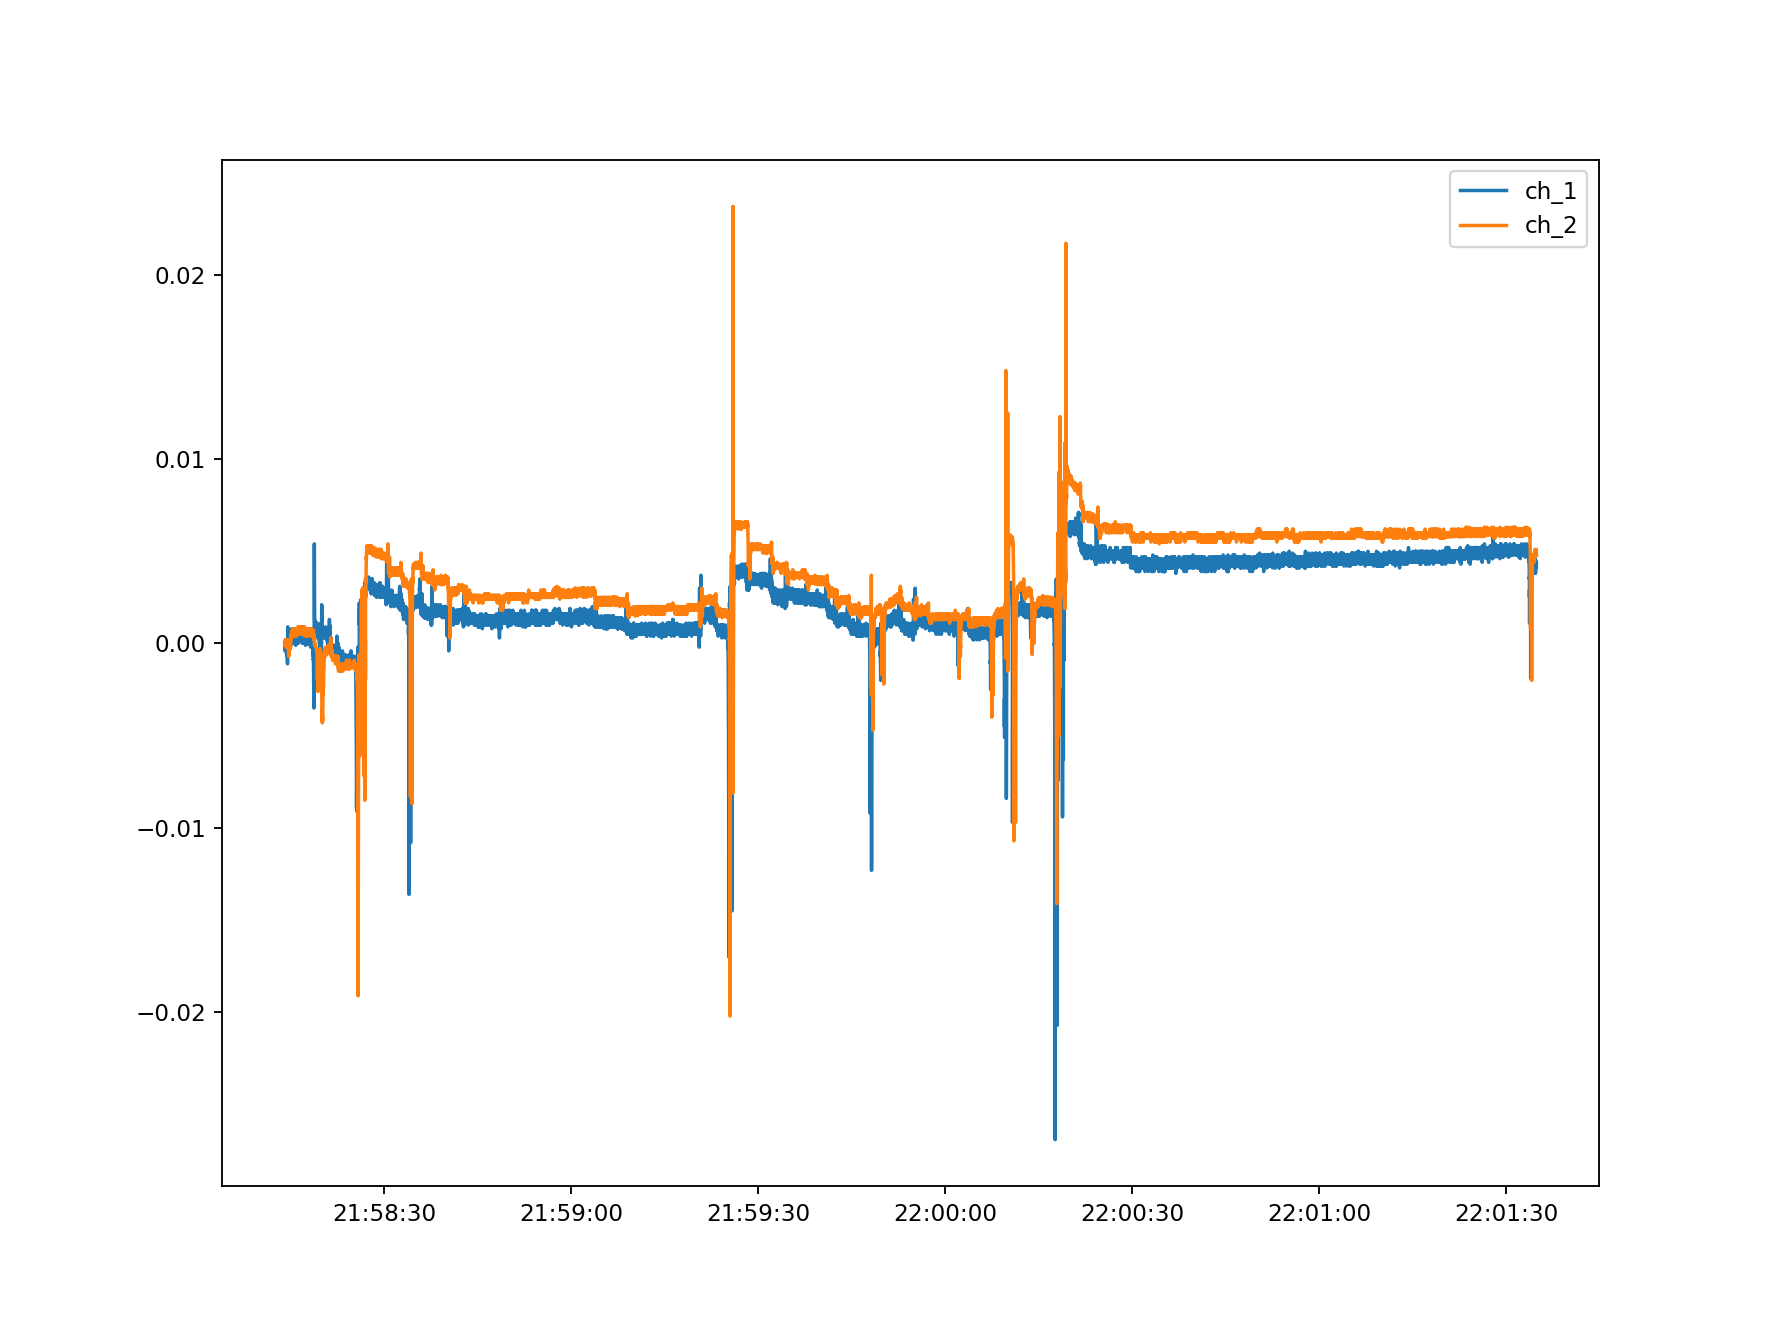

In [4]:
# exam the loaded data
# set index of sensor to look at
import matplotlib.dates as mdates


k = 14
fig = plt.figure(1)
plt.clf()
ax = fig.add_subplot(111)

# if there is a built-in timestamp
ax.plot(df.iloc[:40000, 0].astype('datetime64'), np.asarray(df.iloc[:40000, k])-df.iloc[0,k], label='ch_1')
ax.plot(df2.iloc[:40000, 0].astype('datetime64'), np.asarray(df2.iloc[:40000, k])-df2.iloc[0,k], label='ch_2')

# ax.set_ylim([-0.05, 0.05])

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H-%M-%s-%f'))
# fig.autofmt_xdate()

# ax.plot(np.asarray(df.iloc[:40000, k])-df.iloc[0,k], label='ch_1')
# ax.plot(np.asarray(df2.iloc[:40000, k])-df2.iloc[0,k], label='ch_2')
plt.legend()


In [5]:
event_vis = np.zeros([11000, 25])

for j in range(25):
#     trace_temp = de_trend(df.iloc[:, j]) # detrend or not for initial detection
    trace_temp = df.iloc[:, j+1]
    event_vis_temp = event_detection(trace_temp, threshold=0.002)
    event_vis[:len(event_vis_temp), j] = np.asarray(event_vis_temp)
    print('Processing sensor #{}'.format(j))

Processing sensor #0
Processing sensor #1
Processing sensor #2
Processing sensor #3
Processing sensor #4
Processing sensor #5
Processing sensor #6
Processing sensor #7
Processing sensor #8
Processing sensor #9
Processing sensor #10
Processing sensor #11
Processing sensor #12
Processing sensor #13
Processing sensor #14
Processing sensor #15
Processing sensor #16
Processing sensor #17
Processing sensor #18
Processing sensor #19
Processing sensor #20
Processing sensor #21
Processing sensor #22
Processing sensor #23
Processing sensor #24


2658


<IPython.core.display.Javascript object>


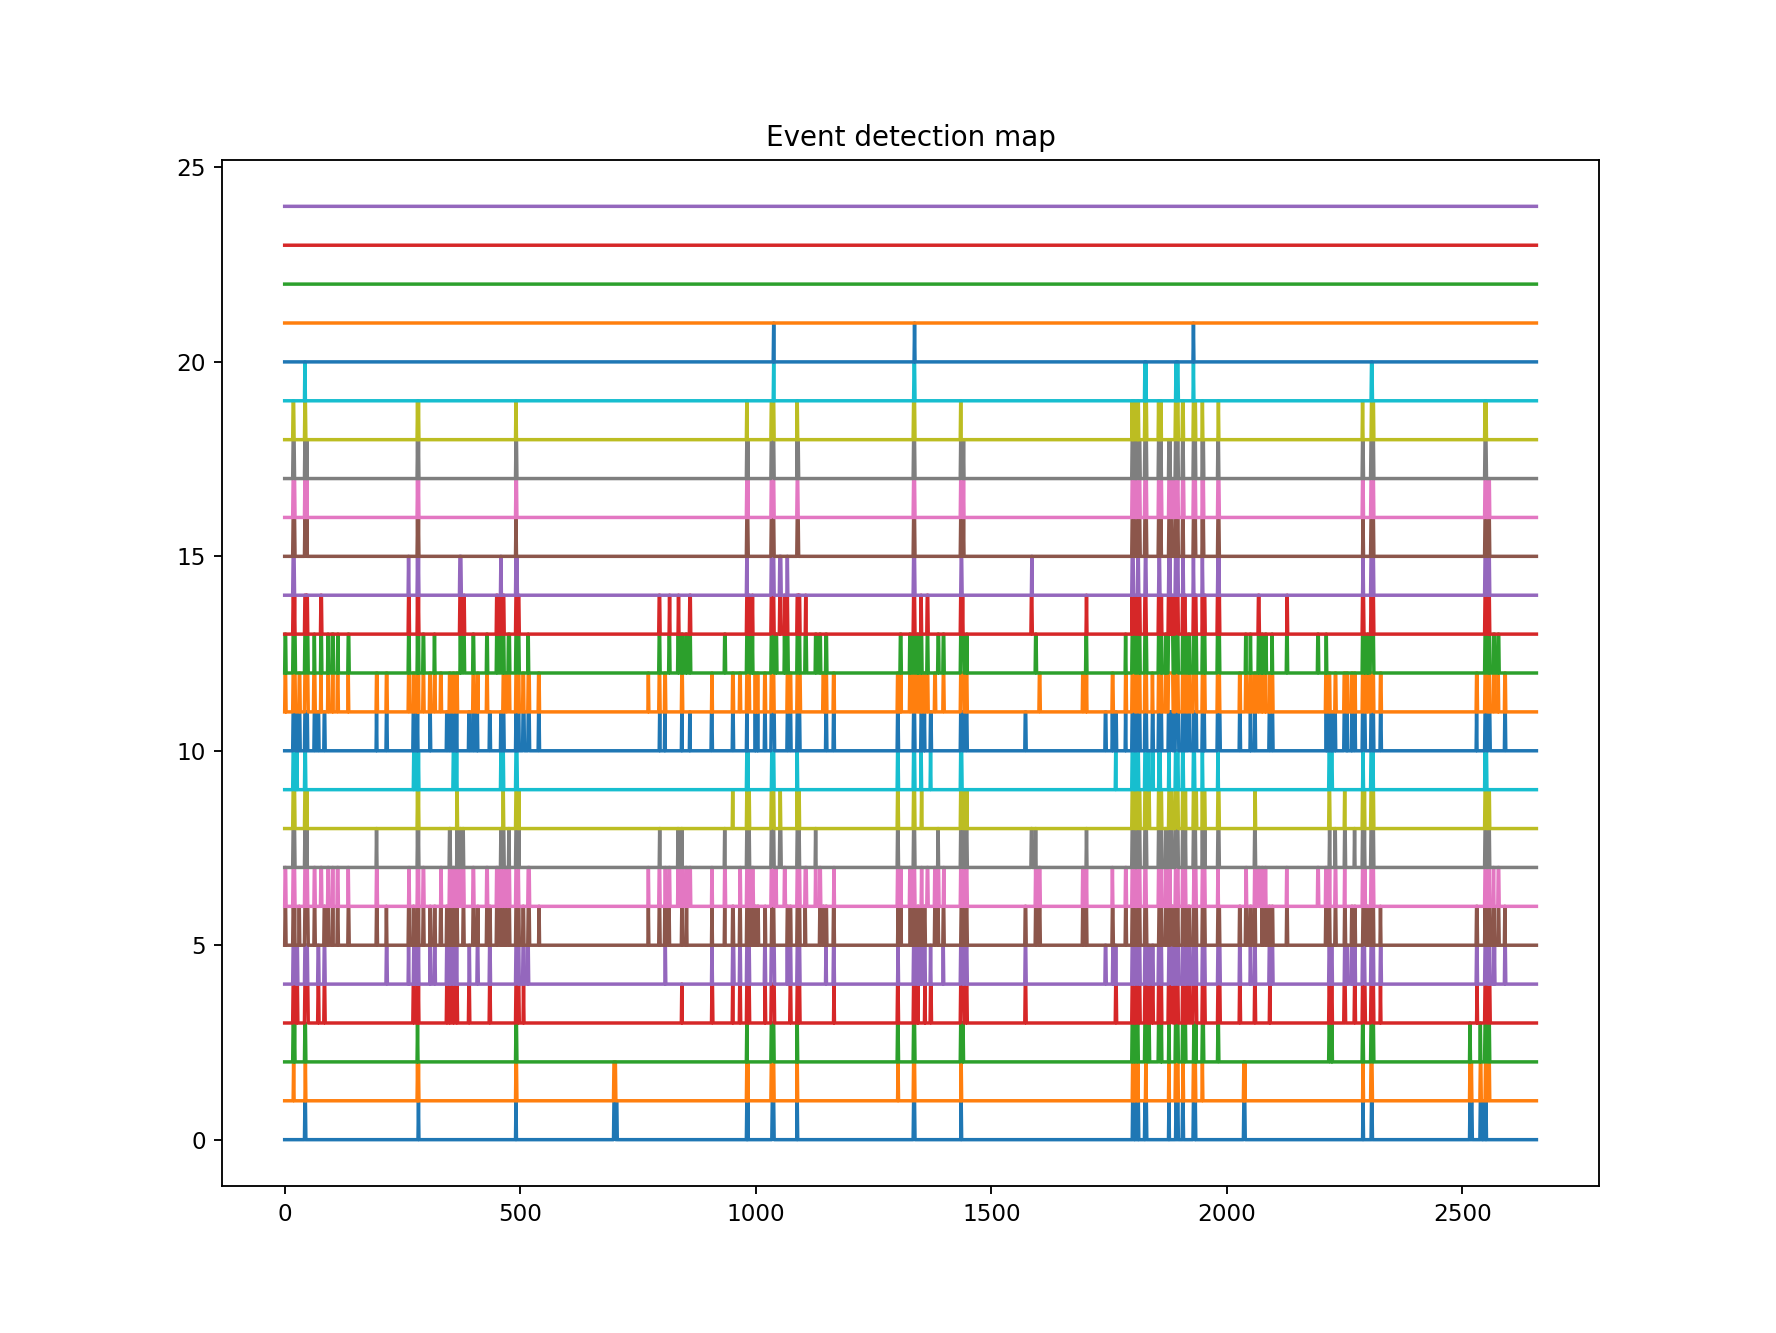

In [6]:
print(len(event_vis_temp))
event_vis = event_vis[:len(event_vis_temp)]
plt.figure(2)
plt.clf()
plt.title('Event detection map')
for j in range(25):

    plt.plot(event_vis[:, j] + 1*j)

<IPython.core.display.Javascript object>


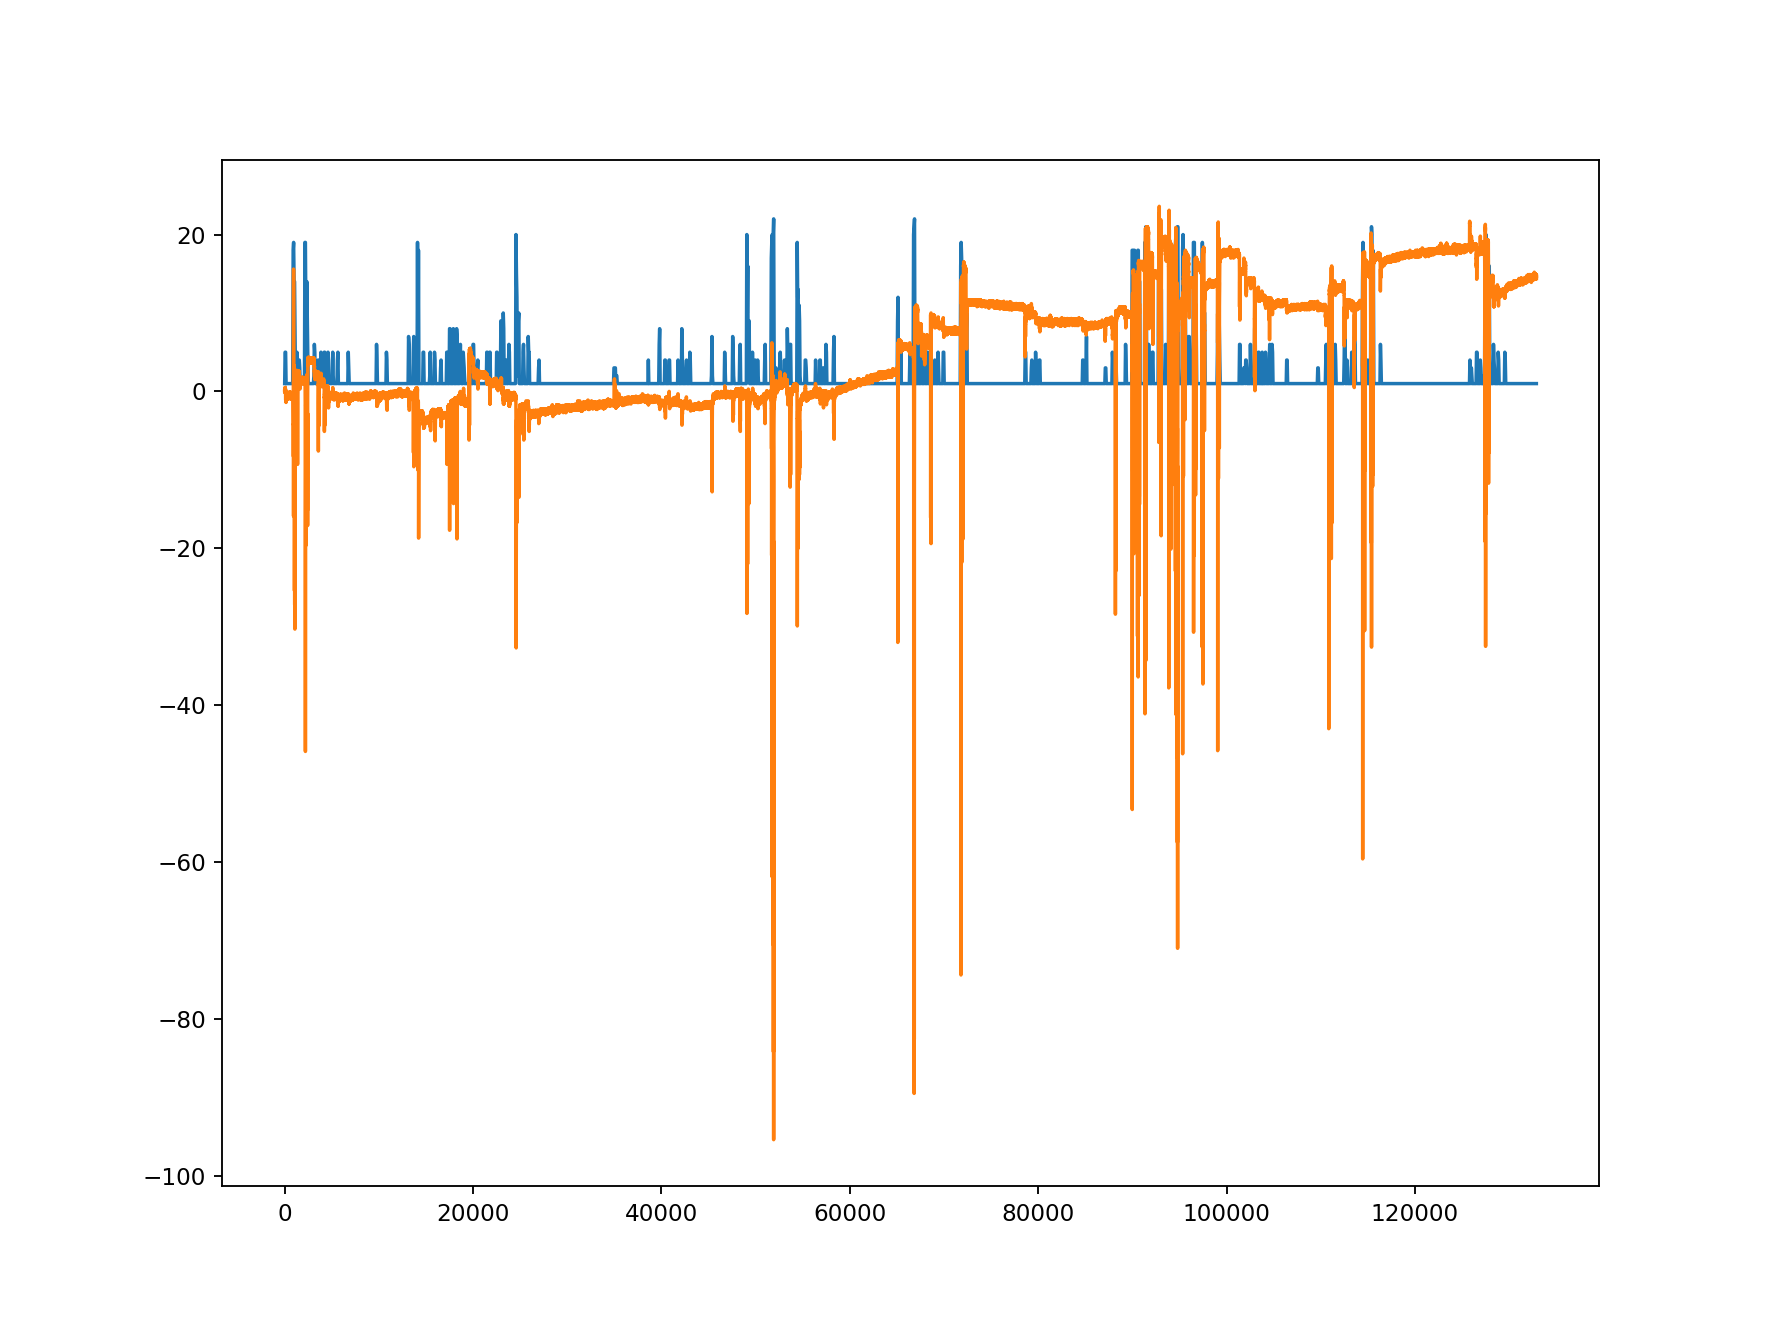

<IPython.core.display.Javascript object>


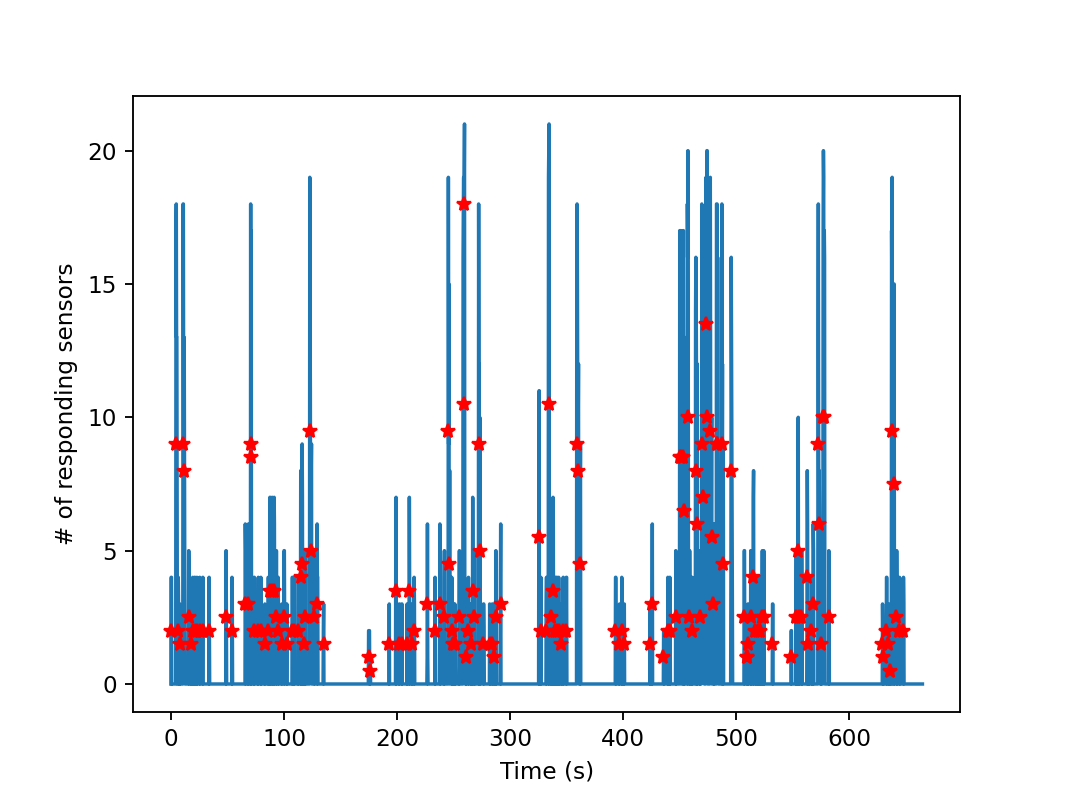

2020-11-19 21:58:14
number of peaks164.


In [7]:
# lane_sensor = [0,1,2,3,4,5,6,7,8,9,10,11,12]
# lane_sensor= [11,12,13,14,15,16,17,18,19,20]
lane_sensor = list(range(25))

combined_event_vis = np.sum(event_vis[:,lane_sensor], axis=1)
combined_event_vis = combined_event_vis[:len(event_vis_temp)]

plt.figure(3)
plt.clf()
timeseg = np.linspace(0, len(event_vis_temp)*BIN_SIZE, len(event_vis_temp))
plt.plot(timeseg, combined_event_vis+1)
plt.plot((np.asarray(df.iloc[:, lane_sensor[4]])-df.iloc[0,lane_sensor[4]])*1000)



plt.figure(4)
plt.clf()
plt.plot(timeseg/SAMPLING_RATE, combined_event_vis, label='event detection by individual sensors')
# plt.plot((timeseg/SAMPLING_RATE)[:len(event_vis_agr)], np.asarray(event_vis_agr)-1.2, label='event detection by aggregated signal')
# plt.legend()
peaks = signal.find_peaks(combined_event_vis, width=1)

plt.plot(peaks[0]*BIN_SIZE/SAMPLING_RATE, peaks[1]['width_heights'], '*r')
plt.ylabel('# of responding sensors')
plt.xlabel('Time (s)')
print(df.iloc[0,0])
print('number of peaks{}.'.format(len(peaks[0])))


In [8]:
event_list = []
event_list2 = []
ap_bin = 3
speed_temp = []

peaks = signal.find_peaks(combined_event_vis, width=1)
# lane_sensor = [0,1,2,3,4,5,6,7,8,9,10]
# lane_sensor= [14,15,16,17,18,19,20,21,22,23,24]
for i in range(len(peaks[0])):
    event_temp = Event()

    event_temp.start = int(peaks[1]['left_bases'][i]*BIN_SIZE)
    event_temp.end = int(peaks[1]['right_bases'][i]*BIN_SIZE)
    if len(event_list)>0:
        if event_temp.start < event_list[-1].end:
            print('overlength event #{}'.format(i))
            continue

    event_temp.timestamp = df.iloc[event_temp.start, 0]
    
    event_temp2 = Event2()
    event_temp2.timestamp = event_temp.timestamp
    event_temp2.event_id = len(event_list)
    event_temp2.fiber1_id = 1
    event_temp2.fiber2_id = 2
    event_temp2.fiber1_sensors = list(range(1, 26))
    event_temp2.fiber2_sensors = list(range(1, 26))
    event_temp2.wav1 = df.iloc[event_temp.start:event_temp.end+BIN_SIZE*ap_bin, 1:26]
    event_temp2.wav1 = event_temp2.wav1.reset_index(drop=True)
    event_temp2.wav1 = np.asarray(subtract_firstrow(event_temp2.wav1))
    event_temp2.wav2 = df2.iloc[event_temp.start:event_temp.end + BIN_SIZE * ap_bin, 1:26]
    event_temp2.wav2 = event_temp2.wav2.reset_index(drop=True)
    event_temp2.wav2 = np.asarray(subtract_firstrow(event_temp2.wav2))
    
    speed_temp2 = calculate_speed_qc_alg1(event_temp2, lane_sensor)
    event_temp.speed = speed_temp2

    # Use speed estimation as a filter to remove outliers
    if speed_temp2 == 0 or speed_temp2 > 200:
        print('speed error at {}'.format(i))
        continue
    if speed_temp2 < 0:
        print('vehicle at opposite lane')
        continue

    speed_temp.append(speed_temp2)
    event_list2.append(event_temp2)
    event_list.append(event_temp)

print('Total event detected: {}'.format(len(event_list)))


overlength event #5
overlength event #41
vehicle at opposite lane
vehicle at opposite lane
overlength event #60
overlength event #66
vehicle at opposite lane
overlength event #93
overlength event #106
vehicle at opposite lane
overlength event #116
overlength event #118
overlength event #120
overlength event #123
speed error at 125
speed error at 128
speed error at 129
overlength event #149
overlength event #152
vehicle at opposite lane
vehicle at opposite lane
vehicle at opposite lane
speed error at 158
Total event detected: 141


In [10]:
# plot VIPER data for comparison

import re
def addtodf(file, timerange='2020-11-09 13:45:29'):
    filename = file
    time_start = datetime.datetime.strptime(timerange, "%Y-%m-%d %H:%M:%S")
    with open(filename, 'r') as f:
        count = 0

        while True:
            b = f.readline()
            b = re.split(r'\t+', b)
            # print(b)
            if count > 2000:
                break

            if count == 0:
                colums = b[:20]
                count = count + 1
                b = f.readline()
                b = re.split(r'\t+', b)
                bseries = b[:20]
                # print(type(bseries))
                df = pd.DataFrame([bseries], columns=colums)
                continue
            current_time = datetime.datetime.strptime(b[0], "%Y/%m/%d %H:%M:%S:%f")
            if current_time < time_start:
                continue
            dftemp = pd.DataFrame([b[:20]], columns=colums)
            df = df.append(dftemp, ignore_index=False)
            # print('length of df:' + str(len(df)))
            count = count + 1
            # ui = input('Continue? Y/N: (Y)')
            # if ui == 'N':
            #     print(count)
            #     break
            # else:
            #     continue
    return df


filename = r'C:\Users\qchen\PARC\Fibridge-PARC - Drive Easy\AustraliaDeploy\Francis\VIPER VIM validation\1120-1122\43_20201122[1].txt'


df = addtodf(filename, timerange='2020-11-20 07:58:14')

df_lan2 = df[df['Lane'].isin(['2'])].reset_index(drop=True)
# df_lan3 = df[df['Lane'].isin(['3', '4'])].reset_index(drop=True)


<IPython.core.display.Javascript object>


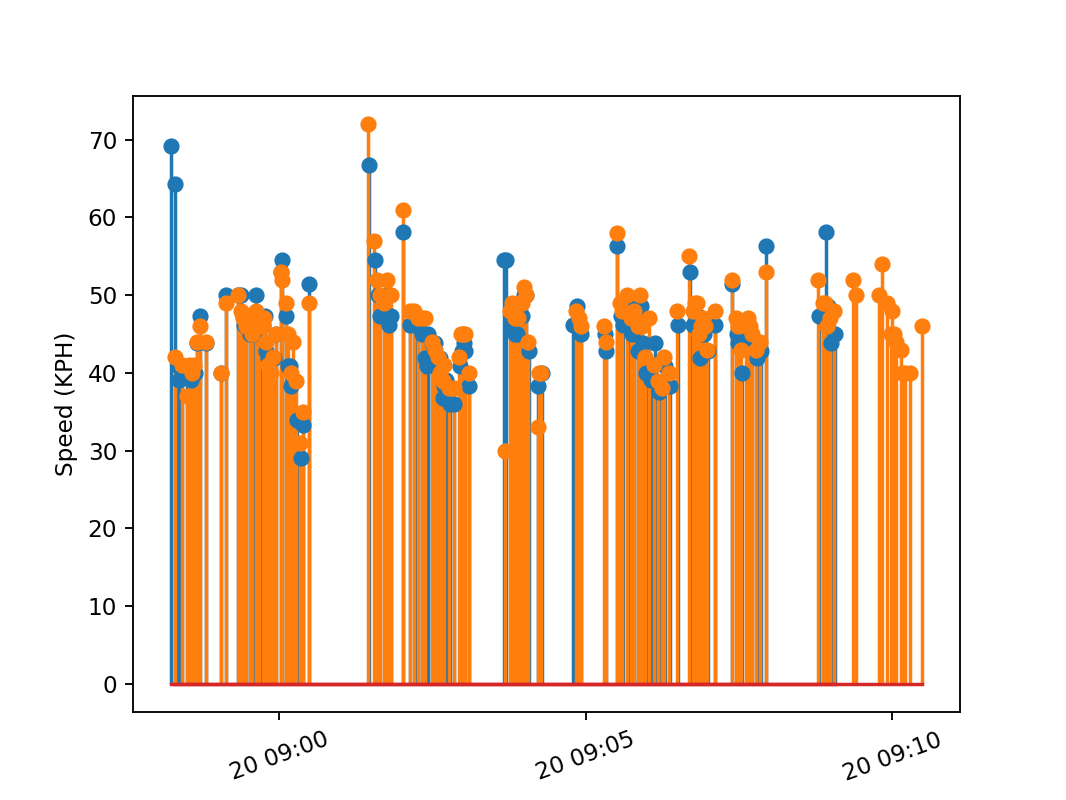

<IPython.core.display.Javascript object>


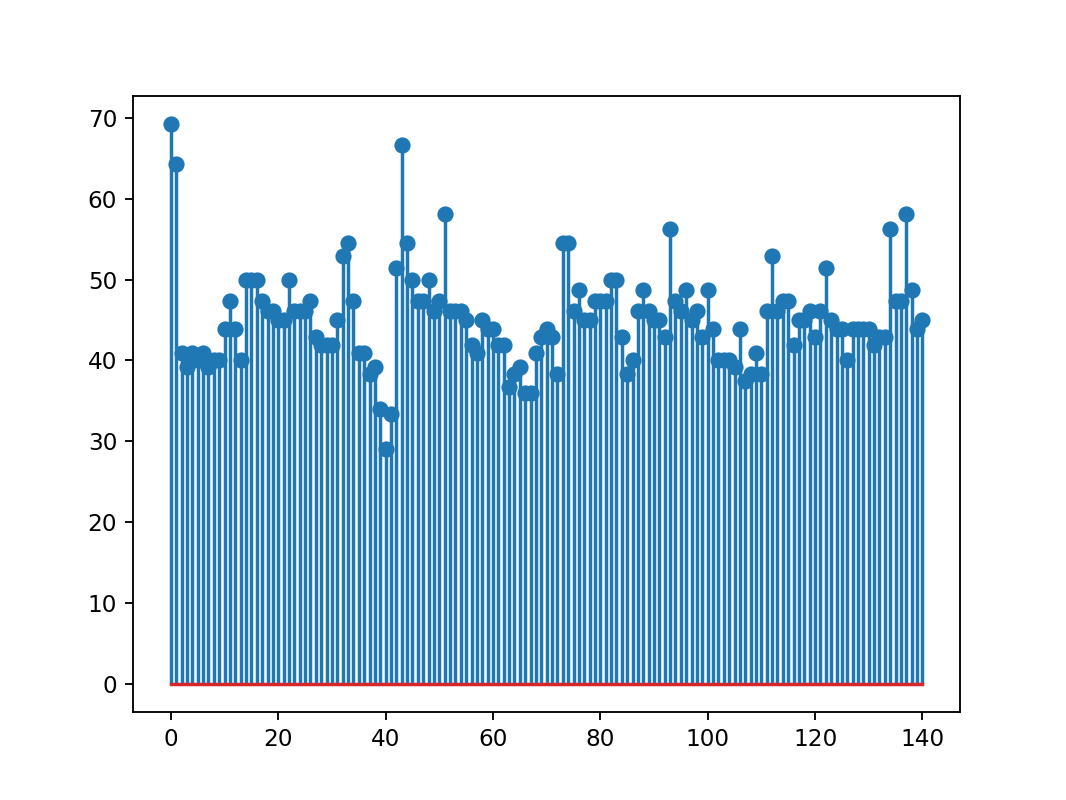

<StemContainer object of 3 artists>

In [11]:
import datetime
plt.figure(9)
plt.clf()
# event_speed = [event_list[k].speed for k in range(len(event_list))]
# event_index = [event_list[k].index for k in range(len(event_list))]
ref_time = [datetime.datetime.strptime(df_lan2.iloc[i, 0], "%Y/%m/%d %H:%M:%S:%f") for i in range(140)]
ref_time = np.asarray(ref_time) + datetime.timedelta(hours=1)
event_speed = speed_temp
event_time = [event_list[k].timestamp for k in range(len(event_list))]
df_time=pd.DataFrame(event_time, columns=['timestamp'])
df_time['timestamp']=df_time['timestamp'].astype("datetime64")+datetime.timedelta(hours=11)
plt.stem(df_time['timestamp'], event_speed, use_line_collection=True)
ref_speed = np.asarray(df_lan2.iloc[:140, 5]).astype('int')
plt.stem(ref_time, ref_speed, markerfmt='C1o', linefmt='C1-', use_line_collection=True)
# plt.stem(event_index, use_line_collection=True)
plt.xticks(rotation=20)
plt.ylabel('Speed (KPH)')

plt.figure(10)
plt.clf()
plt.stem(event_speed, use_line_collection=True)

# plt.stem(ref_speed[4:], use_line_collection=True, markerfmt='C1o')

Total:141. Plotting #24


<IPython.core.display.Javascript object>


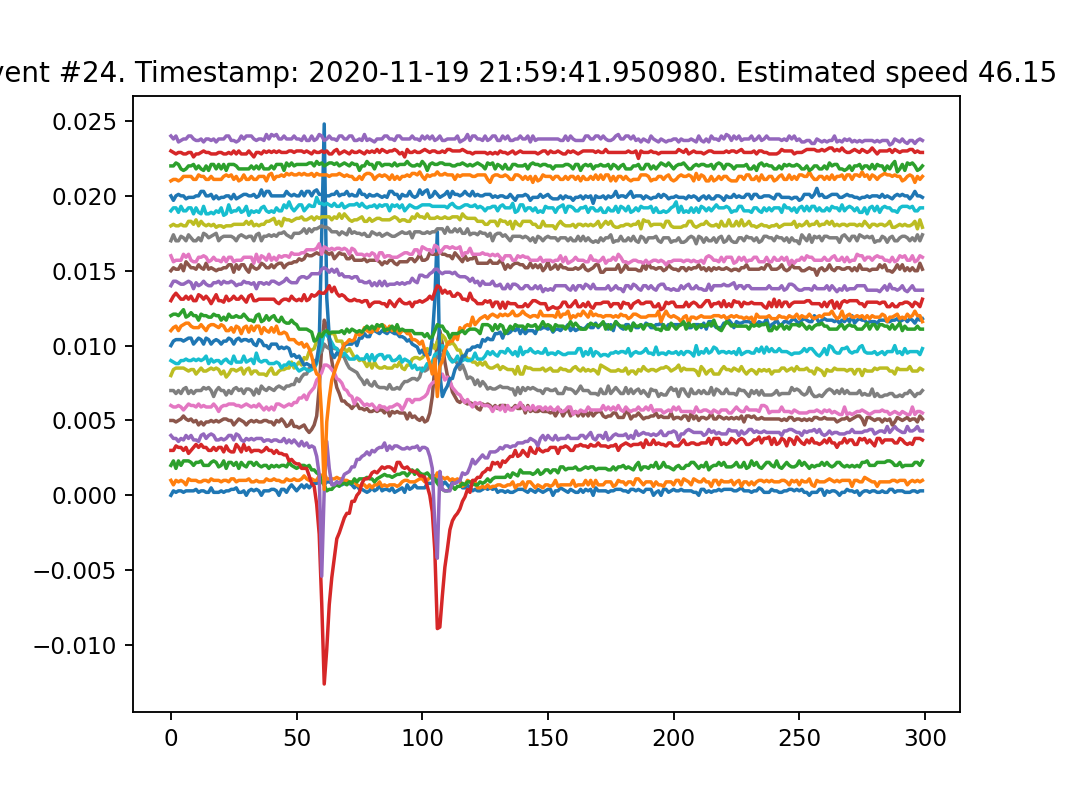

<IPython.core.display.Javascript object>


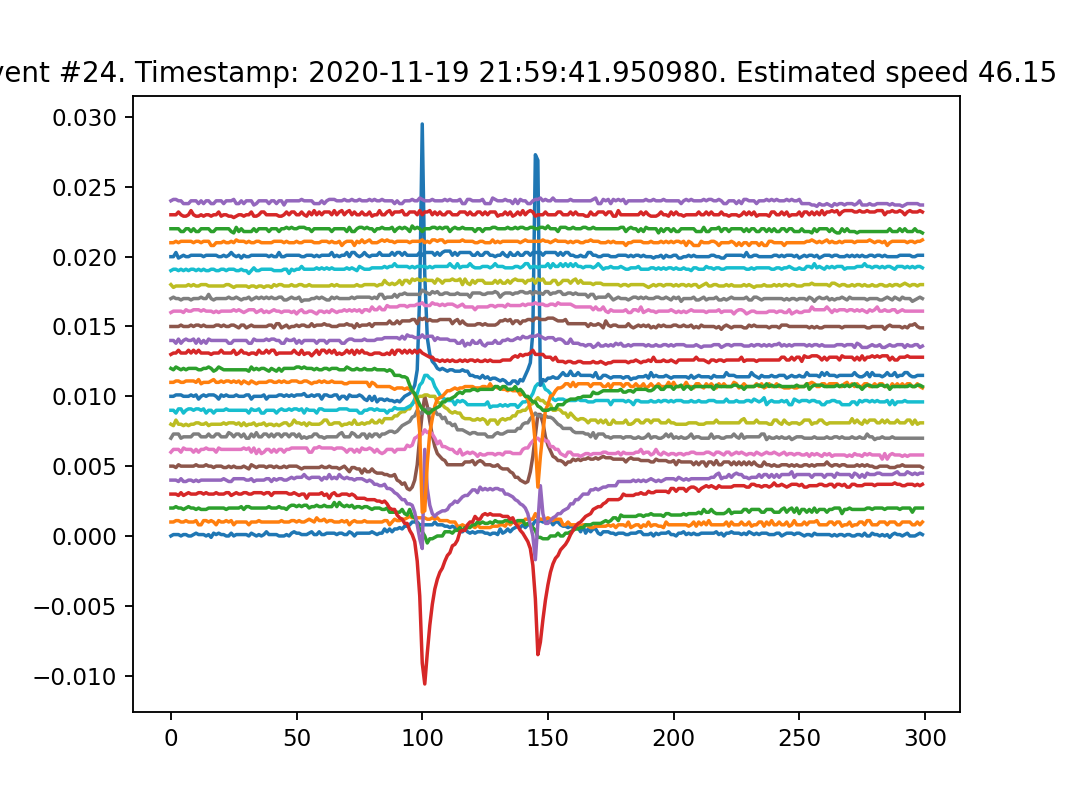

<IPython.core.display.Javascript object>


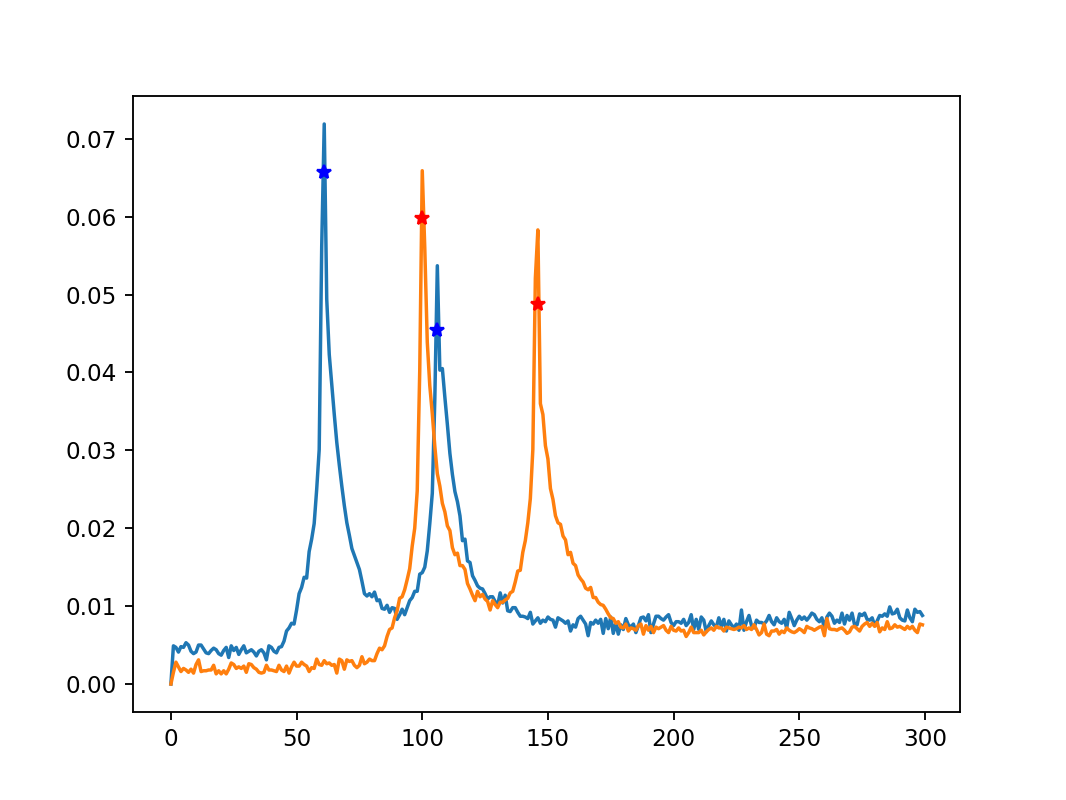

estimated speed_corr (KPH) 45.0


In [20]:
# View extracted event trace
# print(event_temp.data['timestamp'])
j = 24 # event index
print('Total:{}. Plotting #{}'.format(len(event_list), j))

plt.figure(6)
plt.clf()
for i in lane_sensor:
#     plt.plot(event_list[j].data['timestamp'].astype('datetime64'), np.asarray(event_list[j].data['leading'].iloc[:,i]) - event_list[j].data['leading'].iloc[0,i] + 0.001 * i)
    plt.plot(np.asarray(event_list2[j].wav1[:, i] + 0.001 * i))
    plt.title('event #{}. Timestamp: {}. Estimated speed {:2.2f} KPH'.format(j, event_list[j].timestamp, event_list[j].speed))

plt.figure(7)
plt.clf()
for i in lane_sensor:
#     plt.plot(event_list[j].data['timestamp'].astype('datetime64'), np.asarray(event_list[j].data['trailing'].iloc[:,i]) - event_list[j].data['trailing'].iloc[0,i] + 0.001 * i)
    plt.plot(np.asarray(event_list2[j].wav2[:,i]) + 0.001 * i)
    plt.title('event #{}. Timestamp: {}. Estimated speed {:2.2f} KPH'.format(j, event_list[j].timestamp, event_list[j].speed))

plt.figure(8)
plt.clf()

trace_temp1 = np.sum(np.abs(event_list2[j].wav1), axis=1)
peaks_temp1=signal.find_peaks(trace_temp1, prominence=0.005)

plt.plot(trace_temp1)
plt.plot(peaks_temp1[0], peaks_temp1[1]['prominences'],'*b')
trace_temp2 = np.sum(np.abs(event_list2[j].wav2), axis=1)
peaks_temp2=signal.find_peaks(trace_temp2, prominence=0.005)
plt.plot(trace_temp2)
plt.plot(peaks_temp2[0], peaks_temp2[1]['prominences'],'*r')

speed_valid = signal.correlate(trace_temp1, trace_temp2)
speed = -1*2.5/(speed_valid.argmax()-len(event_list2[j].wav1))*SAMPLING_RATE*3.6
print('estimated speed_corr (KPH) {}'.format(speed))


In [ ]:
# save png to folder
# for j in range(len(event_list)):
# #     print('Total:{}. Plotting #{}'.format(len(event_list), j))
#     plt.figure(5)
#     plt.clf()
#     for i in lane_sensor:
#         plt.plot(np.asarray(event_list[j].data['leading'].iloc[:,i]) - event_list[j].data['leading'].iloc[0,i] + 0.001 * i)
#         plt.title('event #{}. Timestamp: {}. Estimated speed {:2.2f} KPH'.format(j, event_list[j].timestamp, event_list[j].speed))
#     plt.savefig('Event#{}_ch3_first12.png'.format(j))
#     plt.clf()
#     for i in lane_sensor:
#         plt.plot(np.asarray(event_list[j].data['trailing'].iloc[:,i]) - event_list[j].data['trailing'].iloc[0,i] + 0.001 * i)
#         plt.title('event #{}. Timestamp: {}. Estimated speed {:2.2f} KPH'.format(j, event_list[j].timestamp, event_list[j].speed))
#     plt.savefig('Event#{}_ch4_first12.png'.format(j))